In [0]:
import torchvision
import torch
import numpy as np

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('Trainig on CPU')
else:
  print('Training on GPU')

Training on GPU


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Количество подпроцессоров для загрузки
num_workers = 0
#Количество батчей загрузки
batch_size = 20
#Процент для тренировочных валидных данных
valid_size = 0.2

#Конвертируем данных в FloatTensor
transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Выберем тренировочные данные и для тестов
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                              download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
print('files successfully downloaded')

Files already downloaded and verified
Files already downloaded and verified
files successfully downloaded


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))

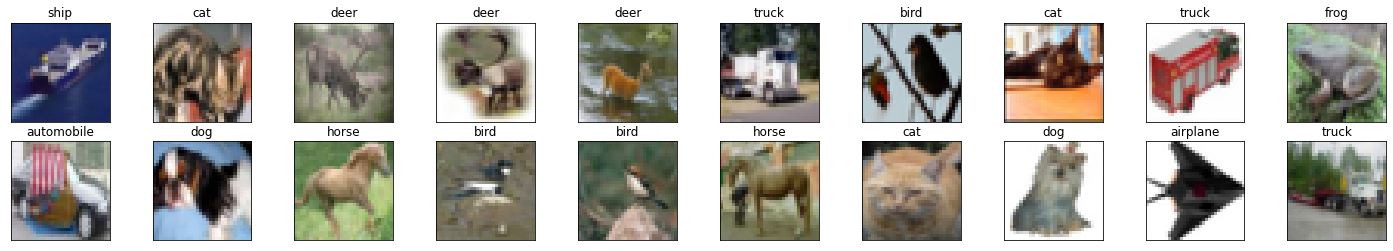

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

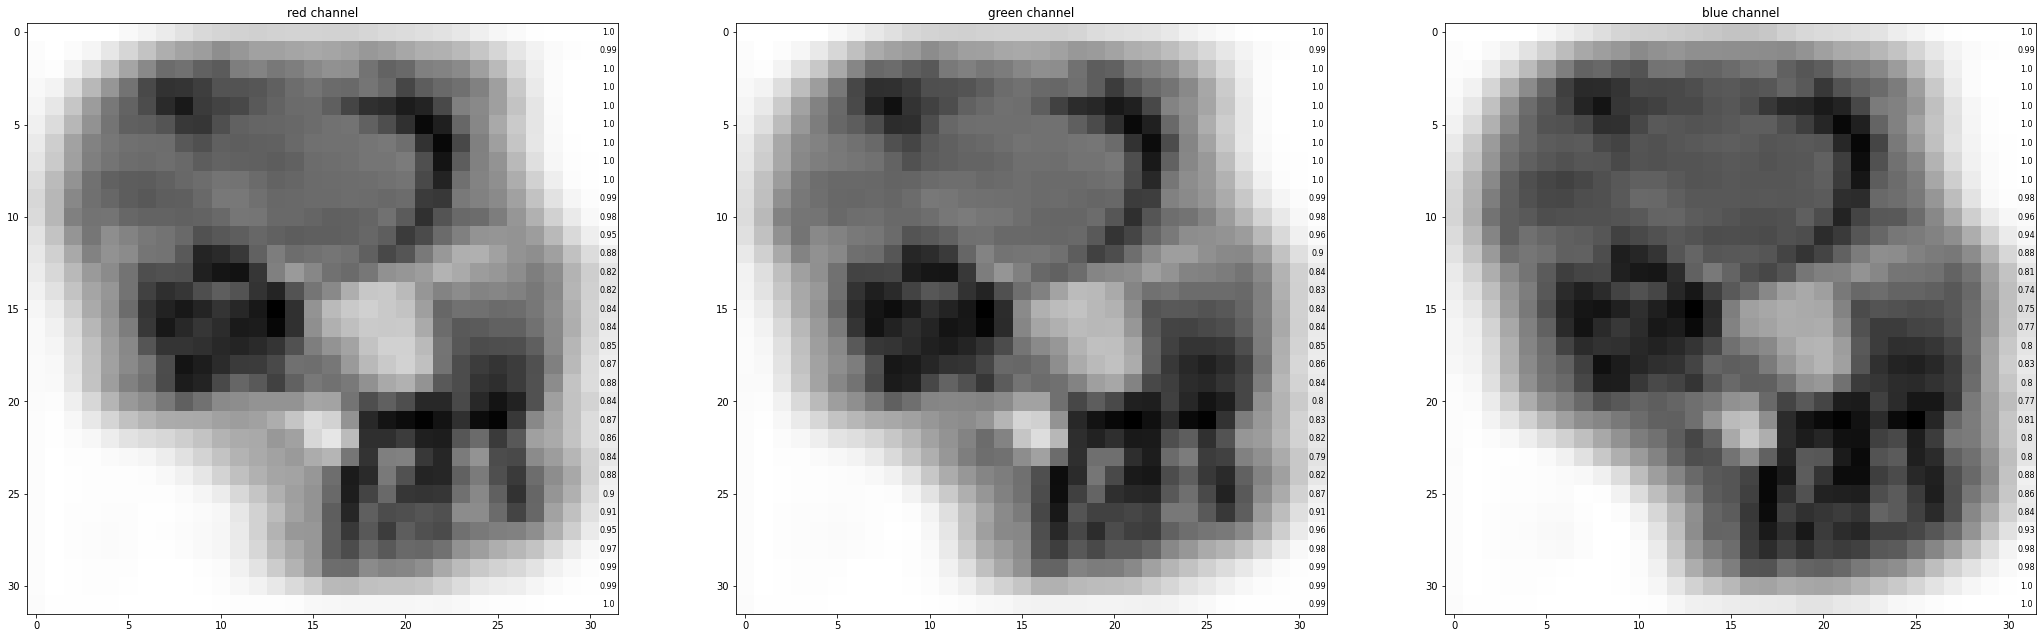

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
  ax = fig.add_subplot(1, 3, idx + 1)
  img = rgb_img[idx]
  ax.imshow(img, cmap='gray')
  ax.set_title(channels[idx])
  width, height = img.shape
  thresh = img.max()/2.5
  for x in range(width):
    for y in range(height):
      if img[x][y] != 0:
        val = round(img[x][y],2)
      else:
        val = 0
      if img[x][y] < thresh:
        color = 'white'
      else:
        color = 'black'
    ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color=color)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0), 
            nn.Tanh(), nn.MaxPool2d(kernel_size=2, stride=2)) 
    self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), 
            nn.Tanh(), nn.MaxPool2d(kernel_size=2, stride=2)) 
    self.layer3 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), 
            nn.Tanh(), nn.MaxPool2d(kernel_size=2, stride=2)) 
    self.drop_out = nn.Dropout() 
    self.fc1 = nn.Sequential(nn.Linear(512, 120), nn.Sigmoid())
    self.fc2 = nn.Linear(120, 10)
  
  def __call__(self, inp):
    out = self.layer1(inp) 
    out = self.layer2(out) 
    out = self.layer3(out)
    out = out.reshape(out.size(0), -1) 
    out = self.drop_out(out) 
    out = self.fc1(out) 
    out = self.fc2(out) 
    #out = self.fc3(out) 
    return out


In [8]:
model = Net()
model.cuda()
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=120, bias=True)
    (1): Sigmoid()
  )
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [0]:
import torch.optim as optim

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [10]:
n_epochs = 17
valid_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):
  train_loss = 0
  valid_loss = 0

  model.train()
  for data, target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()

    output = model(data)

    loss = criterion(output, target)

    loss.backward()

    optimizer.step()

    train_loss = loss.item()*data.size(0)
  
  model.eval()
  for data, target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()

    output = model(data)

    loss = criterion(output, target)

    valid_loss += loss.item()*data.size(0)

  #Средние потери 
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
  
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = valid_loss

  




Epoch: 1 	Training Loss: 0.000465 	Validation Loss: 0.264093
Validation loss decreased (inf --> 0.264093). Saving model ...
Epoch: 2 	Training Loss: 0.000352 	Validation Loss: 0.221826
Validation loss decreased (0.264093 --> 0.221826). Saving model ...
Epoch: 3 	Training Loss: 0.000661 	Validation Loss: 0.207998
Validation loss decreased (0.221826 --> 0.207998). Saving model ...
Epoch: 4 	Training Loss: 0.000495 	Validation Loss: 0.202913
Validation loss decreased (0.207998 --> 0.202913). Saving model ...
Epoch: 5 	Training Loss: 0.000351 	Validation Loss: 0.193177
Validation loss decreased (0.202913 --> 0.193177). Saving model ...
Epoch: 6 	Training Loss: 0.000413 	Validation Loss: 0.185463
Validation loss decreased (0.193177 --> 0.185463). Saving model ...
Epoch: 7 	Training Loss: 0.000265 	Validation Loss: 0.178835
Validation loss decreased (0.185463 --> 0.178835). Saving model ...
Epoch: 8 	Training Loss: 0.000276 	Validation Loss: 0.178645
Validation loss decreased (0.178835 --> 0

In [11]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for data, target in test_loader:
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()

  output = model(data)

  loss = criterion(output, target)

  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)

  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
    classes[i], 100 * class_correct[i] / class_total[i],
    np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.837985

Test Accuracy of airplane: 76% (762/1000)
Test Accuracy of automobile: 82% (828/1000)
Test Accuracy of  bird: 53% (535/1000)
Test Accuracy of   cat: 49% (496/1000)
Test Accuracy of  deer: 69% (697/1000)
Test Accuracy of   dog: 63% (638/1000)
Test Accuracy of  frog: 77% (774/1000)
Test Accuracy of horse: 78% (787/1000)
Test Accuracy of  ship: 81% (810/1000)
Test Accuracy of truck: 80% (802/1000)

Test Accuracy (Overall): 71% (7129/10000)


Мы достигли качества в 71%, выявили при каком количестве эпох модель начинает переобучаться и выбрали оптимальное число 17, также изменили функции активации.

